In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np 
import pandas as pd 
from epiweeks import Week
import matplotlib.pyplot as plt
from bayes_ensemble import *

In [3]:
df_preds_all = pd.read_csv('../predictions/preds_models.csv.gz', index_col = 'Unnamed: 0')
df_preds_all = df_preds_all.rename(columns = {'adm_1': 'state'})
#df_preds_all = df_preds_all.loc[(df_preds_all.model_id != 21) & (df_preds_all.model_id != 25)]
df_preds_all.model_id = df_preds_all.model_id.astype(int)
df_preds_all.head()

,date,pred,lower,upper,state,model_id
0,2022-10-09,110.690113,64.291013,219.826948,AC,21
1,2022-10-16,144.952846,77.564037,279.722708,AC,21
2,2022-10-23,163.613937,92.915072,276.591399,AC,21
3,2022-10-30,170.240443,87.197631,378.407811,AC,21
4,2022-11-06,215.117888,111.835667,445.024983,AC,21


In [4]:
df_preds_problem = df_preds_all.loc[df_preds_all.pred <= 0.1]

excluded_models = list(set(zip(df_preds_problem.model_id, df_preds_problem.state)))

excluded_models

[(21, 'RO'),
 (21, 'RR'),
 (25, 'MG'),
 (21, 'MG'),
 (21, 'ES'),
 (21, 'AL'),
 (25, 'CE')]

In [5]:
df_preds_all = df_preds_all[~df_preds_all.apply(lambda row: (row['model_id'], row['state']) in excluded_models, axis=1)]

df_preds_all.head()

,date,pred,lower,upper,state,model_id
0,2022-10-09,110.690113,64.291013,219.826948,AC,21
1,2022-10-16,144.952846,77.564037,279.722708,AC,21
2,2022-10-23,163.613937,92.915072,276.591399,AC,21
3,2022-10-30,170.240443,87.197631,378.407811,AC,21
4,2022-11-06,215.117888,111.835667,445.024983,AC,21


In [6]:
df_preds_all.loc[(df_preds_all.pred <= 0.1)].state.unique()

array([], dtype=object)

In [7]:
df_preds_all.loc[(df_preds_all.pred <= 0.1) & (df_preds_all.model_id == 25)].state.unique()

array([], dtype=object)

In [8]:
models_by_state = df_preds_all.groupby('state')['model_id'].agg(lambda x: list(set(x))).reset_index()
models_by_state.head()

,state,model_id
0,AC,"[34, 21, 22, 27, 28, 30]"
1,AL,"[34, 22, 27, 28, 30]"
2,AM,"[34, 21, 22, 27, 28, 30]"
3,AP,"[34, 21, 22, 27, 28, 30]"
4,BA,"[34, 21, 22, 27, 28, 30]"


In [9]:
states_ne = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'SE', 'RN']
states_se = ['SP', 'RJ', 'ES', 'MG']
states_sul = ['RS', 'SC', 'PR' ]
states_ce = ['DF', 'MT', 'MS', 'GO']
states_no = ['AP', 'TO', 'RR', 'RO', 'AM' ,'AC', 'PA']

states_BR = states_ne+states_se+states_no+states_ce+states_sul

In [10]:
dates_23 = pd.date_range(start= Week(2022, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2023, 39).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

dates_24 = pd.date_range(start= Week(2023, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2024, 23).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

dates_25 = pd.date_range(start= Week(2024, 41).startdate().strftime('%Y-%m-%d'),
              end= Week(2025, 40).startdate().strftime('%Y-%m-%d'),
              freq='W-SUN')

data_all = pd.read_csv('../data/dengue_uf.csv.gz')
data_all.date = pd.to_datetime(data_all.date)


In [11]:
data_all.date.max()

Timestamp('2024-08-04 00:00:00')

In [12]:
Week.fromdate(pd.to_datetime('2024-08-04'))

Week(2024, 32, CDC)

In [13]:
df_ens_end = pd.DataFrame()
df_weights_end = pd.DataFrame()

for STATE in states_BR:

    models = sorted(models_by_state.loc[models_by_state.state == STATE]['model_id'].values[0])
    
    data = data_all.loc[data_all.uf == STATE].reset_index(drop = True)

    data_23 = data.loc[data.date.isin(dates_23)]
    data_24 = data.loc[data.date.isin(dates_24)]

    preds = df_preds_all.loc[df_preds_all.state == STATE]
    
    preds.date = pd.to_datetime(preds.date)
    #preds = preds.loc[preds.model_id.isin(models)]

    preds_23 = preds.loc[preds.date.isin(dates_23)]
    preds_23 = preds_23.drop_duplicates(subset=['date', 'model_id'], keep='first').reset_index(drop=True)
    
    preds_24 = preds.loc[preds.date.isin(dates_24)]
    preds_24 = preds_24.drop_duplicates(subset=['date', 'model_id'], keep='first').reset_index(drop=True)

    preds_25 = preds.loc[preds.date.isin(dates_25)]
    preds_25 = preds_25.drop_duplicates(subset=['date', 'model_id'], keep='first').reset_index(drop=True)
    
    weights_23 = find_opt_CRPS_weights_all(obs=data_23, preds=preds_23[['pred', 'lower', 'upper', 'date', 'model_id']], order_models = models)
    
    weights_24 = find_opt_CRPS_weights_all(obs=data_24, preds=preds_24[['pred', 'lower', 'upper', 'date', 'model_id']], order_models = models)


    df_weights_ = pd.DataFrame()

    df_weights_['weights_23'] = weights_23['weights']

    df_weights_['weights_24'] = weights_24['weights']
    
    df_weights_['model_id'] = models

    df_weights_['state'] = STATE

    df_weights_end = pd.concat([df_weights_end, df_weights_])
    
    df_for_23 = get_forecast(weights_23['weights'], preds_25)
    df_for_23.set_index('date', inplace = True)
    df_for_23.columns = df_for_23.columns + '_ensemble_23'
    df_for_24 = get_forecast(weights_24['weights'], preds_25)
    df_for_24.set_index('date', inplace = True)
    df_for_24.columns = df_for_24.columns + '_ensemble_24'

    df_ens = pd.concat([df_for_23, df_for_24], axis =1)
    df_ens['state'] = STATE

    df_ens_end = pd.concat([df_ens_end, df_ens])

    '''
    fig,ax = plt.subplots()

    ax.plot(df_ens.index, df_ens.pred_ensemble_23, color = 'tab:red', label = 'Ensemble (2023)')

    ax.fill_between(df_ens.index, df_ens.lower_ensemble_23, df_ens.upper_ensemble_23, color = 'tab:red', alpha = 0.1)

    ax.plot(df_ens.index, df_ens.pred_ensemble_24, color = 'tab:orange', label = 'Ensemble (2024)')
    
    ax.fill_between(df_ens.index, df_ens.lower_ensemble_24, df_ens.upper_ensemble_24, color = 'tab:orange', alpha = 0.1)

    ax.set_title(f'Forecast - {STATE} - 2025')

    ax.legend()

    plt.show()
    '''


In [14]:
df_ens_end

,pred_ensemble_23,lower_ensemble_23,upper_ensemble_23,pred_ensemble_24,lower_ensemble_24,upper_ensemble_24,state
date,,,,,,,
2024-10-06,202.032261,45.000038,907.044440,142.059686,135.451504,148.990257,AL
2024-10-13,199.109150,44.002558,900.957931,152.214298,145.297707,159.460138,AL
2024-10-20,199.654993,43.997476,906.009161,141.058088,134.486915,147.950336,AL
2024-10-27,201.801720,44.999429,904.987804,140.472735,133.913962,147.352740,AL
2024-11-03,199.317950,43.999601,902.909223,164.235303,156.956970,171.851143,AL
...,...,...,...,...,...,...,...
2025-08-31,1071.069717,383.952593,2987.843709,5062.455151,1278.444112,20046.595629,PR
2025-09-07,1244.349705,448.164031,3454.998802,5752.336459,1458.257708,22691.033660,PR
2025-09-14,1006.742966,387.028038,2618.754458,6255.617286,1585.037657,24688.844113,PR


In [15]:
df_ens_end.shape

(1404, 7)

In [19]:
df_weights_end

,weights_23,weights_24,model_id,state
0,1.000000e+00,1.095030e-27,22,AL
1,2.142976e-25,8.493215e-01,27,AL
2,2.008763e-19,1.157358e-31,28,AL
3,2.049586e-16,3.406100e-16,30,AL
4,0.000000e+00,1.506785e-01,34,AL
...,...,...,...,...
2,3.551999e-19,2.152290e-19,25,PR
3,5.375173e-03,2.666837e-19,27,PR
4,1.509144e-14,2.163549e-03,28,PR
5,0.000000e+00,0.000000e+00,30,PR


In [17]:
df_weights_end.to_csv('../predictions/weights_bayes.csv.gz')

In [18]:
df_ens_end.to_csv('../predictions/ensemble_bayes_2025.csv.gz')

### Single state validation for report: 

In [11]:
for STATE in ['GO']:

    if STATE in ['SC', 'RS', 'RJ', 'SP']:

        models = [ 22, 27, 30, 34]
        
    elif STATE in ['ES', 'RR']:

        models = [22, 30, 34]        

    elif STATE in ['DF', 'AC', 'AP']:
        models = [ 22, 30,34]

    elif STATE in ['AL', 'MG', 'RO']:
        models = [22,27,28,30,34]
    
    else:
        models = [ 22,27,28,30,34]
    
    
    data = data_all.loc[data_all.uf == STATE].reset_index(drop = True)

    data_23 = data.loc[data.date.isin(dates_23)]
    data_24 = data.loc[data.date.isin(dates_24)]

    preds = pd.read_csv(f'./predictions/preds_{STATE}.csv', index_col = 'Unnamed: 0')
    
    preds.date = pd.to_datetime(preds.date)
    preds = preds.loc[preds.model_id.isin(models)]

    preds_23 = preds.loc[preds.date.isin(dates_23)]
    preds_23 = preds_23.drop_duplicates(subset=['date', 'model_id'], keep='first').reset_index(drop=True)
    
    preds_24 = preds.loc[preds.date.isin(dates_24)]
    preds_24 = preds_24.drop_duplicates(subset=['date', 'model_id'], keep='first').reset_index(drop=True)

    preds_25 = preds.loc[preds.date.isin(dates_25)]
    preds_25 = preds_25.drop_duplicates(subset=['date', 'model_id'], keep='first').reset_index(drop=True)
    
    weights_23 = find_opt_CRPS_weights_all(obs=data_23, preds=preds_23[['pred', 'lower', 'upper', 'date', 'model_id']], order_models = models)
    
    weights_24 = find_opt_CRPS_weights_all(obs=data_24, preds=preds_24[['pred', 'lower', 'upper', 'date', 'model_id']], order_models = models)

    df_s_23 = get_forecast(weights_23['weights'], preds_23)
    df_s_23.set_index('date', inplace = True)
    
    df_s_24 = get_forecast(weights_24['weights'], preds_24)
    df_s_24.set_index('date', inplace = True)


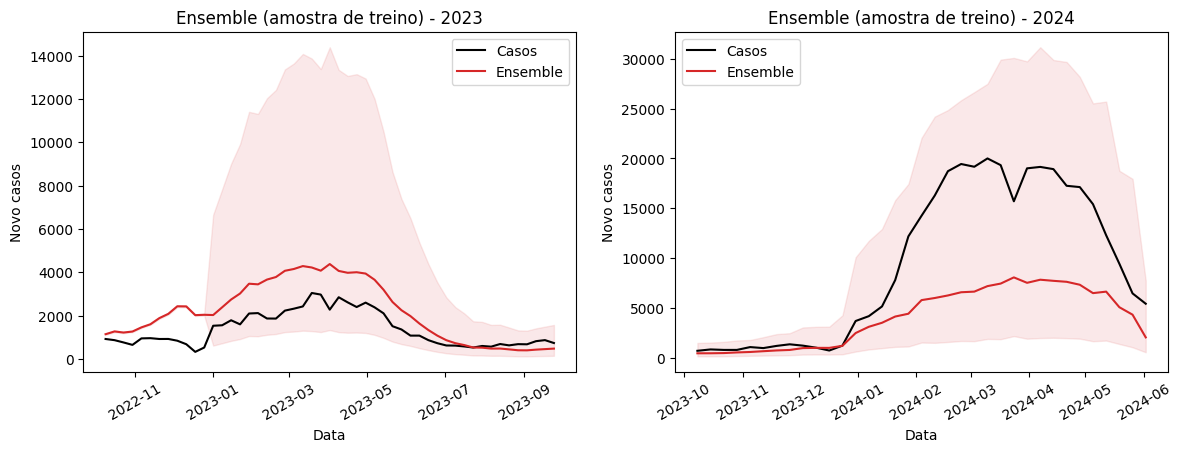

In [12]:
fig, ax = plt.subplots(1,2, figsize = (14, 5))

ax[0].plot(data_23.date, data_23.casos, color = 'black', label = 'Casos')

ax[0].plot(df_s_23.index, df_s_23.pred, color = 'tab:red', label = 'Ensemble')

ax[0].fill_between(df_s_23.index, df_s_23.lower, df_s_23.upper, color = 'tab:red', alpha = 0.1)

ax[0].set_title('Ensemble (amostra de treino) - 2023')

ax[1].plot(data_24.date, data_24.casos, color = 'black', label = 'Casos')

ax[1].plot(df_s_24.index, df_s_24.pred, color = 'tab:red', label = 'Ensemble')

ax[1].fill_between(df_s_24.index, df_s_24.lower, df_s_24.upper, color = 'tab:red', alpha = 0.1)

ax[1].set_title('Ensemble (amostra de treino) - 2024')

for ax_ in [ax[0], ax[1]]:

    ax_.set_xlabel('Data')
    ax_.set_ylabel('Novo casos')
    ax_.legend()

fig.autofmt_xdate(ha='center')

plt.savefig('ensemble_validation_in_sample.png', dpi = 300, bbox_inches = 'tight')
        
plt.show()

In [13]:
preds = pd.read_csv(f'./predictions/preds_ES.csv', index_col = 'Unnamed: 0')
preds = preds.loc[preds.model_id == 34]
preds.date = pd.to_datetime(preds.date)
preds_25 = preds.loc[preds.date.isin(dates_25)]
preds.head()

,date,pred,lower,upper,adm_0,adm_1,model_id
0,2022-10-09,266.077832,0.0,553.713119,BRA,ES,34
1,2022-10-16,251.290715,0.0,538.926002,BRA,ES,34
2,2022-10-23,284.654575,0.0,572.289863,BRA,ES,34
3,2022-10-30,265.910953,0.0,553.546241,BRA,ES,34
4,2022-11-06,274.465674,0.0,562.100961,BRA,ES,34


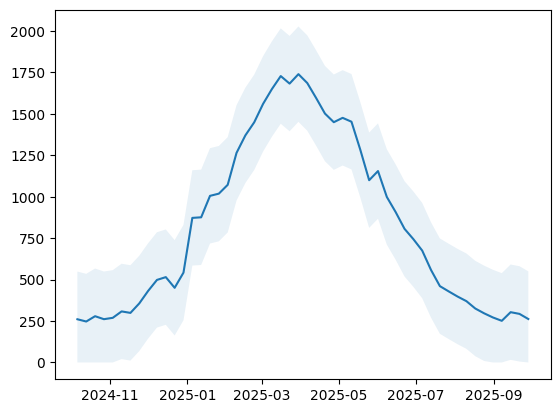

In [14]:
fig,ax = plt.subplots()

ax.plot(preds_25.date, preds_25.pred)

ax.fill_between(preds_25.date, preds_25.lower, preds_25.upper, alpha= 0.1)